<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="https://mng.bz/lZ5B">Build a Reasoning Model (From Scratch)</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/reasoning-from-scratch">https://github.com/rasbt/reasoning-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="https://mng.bz/lZ5B"><img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 5: Inference-Time Scaling Via Self-Refinement

Packages that are being used in this notebook:

In [1]:
from importlib.metadata import version

used_libraries = [
    "matplotlib",
    "reasoning_from_scratch",
    "torch",
    "tokenizers"  # Used by reasoning_from_scratch
]

for lib in used_libraries:
    print(f"{lib} version: {version(lib)}")

matplotlib version: 3.10.8
reasoning_from_scratch version: 0.1.13
torch version: 2.10.0
tokenizers version: 0.22.2


<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F01_raschka.webp" width=600>

&nbsp;
## 5.1 Scoring and iteratively improving model responses

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F02_raschka.webp" width=600>

- No code in this section

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F03_raschka.webp" width=600>

&nbsp;
## 5.2 Loading a pre-trained model

- Model loading code similar to chapter 2-4

- Note that we hardcode the `"cpu"` device below to make the results as similar as possible across different machines and operating systems
- I recommend running the chapter code here as is before deleting `device = torch.device("cpu")` below
- Even though we hardcode the `"cpu"` device, since the chapter involves the multiplication of many very small numbers, the results may differ on your computer (especially in section 5.4 and onward)

In [2]:
import torch

from reasoning_from_scratch.ch02 import get_device
from reasoning_from_scratch.ch03 import (
     load_model_and_tokenizer
)

device = get_device()
device = torch.device("cpu")  # optionally delete to allow running on GPU

model, tokenizer = load_model_and_tokenizer(
    which_model="base",
    device=device,
    use_compile=False
)

Using Apple Silicon GPU (MPS)
✓ qwen3/qwen3-0.6B-base.pth already up-to-date


- Let's try the model on a prompt from the MATH-500 dataset, which we worked with in the previous chapter:

In [3]:
from reasoning_from_scratch.ch03 import render_prompt
from reasoning_from_scratch.ch04 import (
    generate_text_stream_concat_flex,
    generate_text_top_p_stream_cache
)

raw_prompt = (
    "Half the value of $3x-9$ is $x+37$. "
    "What is the value of $x$?"
)
prompt = render_prompt(raw_prompt)
prompt_cot = prompt + "\n\nExplain step by step."

torch.manual_seed(0)
response_1 = generate_text_stream_concat_flex(
    model, tokenizer, prompt_cot, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.9,
    top_p=0.9
)

 ### Step 1: Understand the Problem

The problem states that half the value of \( 3x - 9 \) is \( x + 37 \). We need to find the value of \( x \).

### Step 2: Translate the Statement into an Equation

Let's translate the given statement into an equation. Half the value of \( 3x - 9 \) means we take \( 3x - 9 \) and divide it by 2. So, the equation becomes:

\[
\frac{1}{2}(3x - 9) = x + 37
\]

### Step 3: Solve the Equation

To solve for \( x \), we'll follow these steps:

1. **Multiply both sides by 2** to eliminate the fraction:

\[
2 \times \frac{1}{2}(3x - 9) = 2 \times (x + 37)
\]

This simplifies to:

\[
3x - 9 = 2x + 74
\]

2. **Subtract \( 2x \) from both sides** to get all \( x \)-terms on one side:

\[
3x - 2x - 9 = 74
\]

This simplifies to:

\[
x - 9 = 74
\]

3. **Add 9 to both sides** to isolate \( x \):

\[
x - 9 + 9 = 74 + 9
\]

This simplifies to:

\[
x = 83
\]

### Step 4: Verify the Solution

It's always a good idea to verify the solution by plugging \( x = 83 \) back

In [4]:
torch.manual_seed(3)
response_2 = generate_text_stream_concat_flex(
    model, tokenizer, prompt_cot, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.9,
    top_p=0.9, 
)

 We start with the given equation:

\[
\frac{1}{2}(3x - 9) = x + 37
\]

**Step 1:** Simplify the left side of the equation.

\[
\frac{1}{2}(3x - 9) = \frac{3x - 9}{2}
\]

So the equation becomes:

\[
\frac{3x - 9}{2} = x + 37
\]

**Step 2:** Eliminate the fraction by multiplying both sides by 2.

\[
2 \cdot \frac{3x - 9}{2} = 2(x + 37)
\]

This simplifies to:

\[
3x - 9 = 2x + 74
\]

**Step 3:** Subtract \(2x\) from both sides to get all \(x\) terms on one side.

\[
3x - 2x - 9 = 74
\]

This simplifies to:

\[
x - 9 = 74
\]

**Step 4:** Add 9 to both sides to solve for \(x\).

\[
x = 74 + 9
\]

\[
x = 83
\]

**Final Answer:**

\[
\boxed{83}
\]

In [5]:
print("Response 1 characters:", len(response_1))
print("Response 1 tokens:", len(tokenizer.encode(response_1)))
print("\nResponse 2 characters:", len(response_2))
print("Response 2 tokens:", len(tokenizer.encode(response_2)))

Response 1 characters: 1422
Response 1 tokens: 537

Response 2 characters: 651
Response 2 tokens: 284


- By the way, the correct answer is 83

&nbsp;
## 5.3 Scoring LLM responses with a rule-based score

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F04_raschka.webp" width=600>

- Can be used as a tie breaker for self-consistency
- Or can be used to score and rank all self-consistency responses (this is known as Best-of-N inference-scaling)

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F05_raschka.webp" width=600>

In [6]:
from reasoning_from_scratch.ch03 import extract_final_candidate
import math

def heuristic_score(
    answer,
    prompt=None,  # Placeholder that is ignored
    brevity_bonus=500.0,
    boxed_bonus=2.0,
    extract_bonus=1.0,
    fulltext_bonus=0.0,
):
    score = 0.0

    # Reward answers that have a final boxed value
    cand = extract_final_candidate(answer, fallback="none")
    if cand:
        score += boxed_bonus

    # Give weaker rewards if answer doesn't have a boxed value
    else:
        cand = extract_final_candidate(answer, fallback="number_only")
        if cand:
            score += extract_bonus
        else:
            cand = extract_final_candidate(
                answer, fallback="number_then_full"
            )
            if cand:
                score += fulltext_bonus

    # Add a brevity reward that decays with text length
    score += 1.5 * math.exp(-len(answer) / brevity_bonus)
    return score

- Note that the code measures the number of characters, instead of tokens, for simplicity, so we don't have to pass a tokenizer here, but this can easily be changed

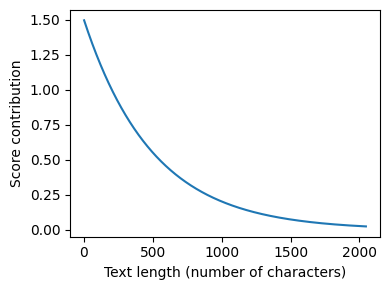

In [7]:
import matplotlib.pyplot as plt

def plot_brevity_curve(brevity_bonus, max_len=2048):
    lengths = torch.arange(1, max_len)
    scores = 1.5 * torch.exp(-lengths / brevity_bonus)

    plt.figure(figsize=(4, 3))
    plt.plot(lengths, scores)
    plt.xlabel("Text length (number of characters)")
    plt.ylabel("Score contribution")
    plt.tight_layout()
    #plt.savefig("brevity_curve.pdf")
    plt.show()

plot_brevity_curve(500)

In [8]:
print(round(heuristic_score(response_1), 3))

2.087


In [9]:
print(round(heuristic_score(response_2), 3))

2.408


&nbsp;
## 5.4 Understanding token probability scores

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F07_raschka.webp" width=600>

- Also called token likelihoods
- Implement a function to score the generated texts
- We will use this for the upcoming self-refinement approach, but similar to the `heuristic_score`, this can also be used as a tie-breaker in the self-consistency approach
- The score could technically be calculated as part of the `generate_text_top_p_stream_cache` function in section 4.5, to improve efficiency, but here we keep it separate so it is a pluggable scoring function like `heuristic_score`

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F08_raschka.webp" width=600>

- The above is a figure from the previous chapter that illustrates how the next token is generated
- Here, we are interested in just the scores for different next token options, not actually generating it

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F09_raschka.webp" width=600>

- For simplicity, the above showed the logits score, but it's more interpretable if we use probabilities (token likelihoods)

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F10_raschka.webp" width=600>

- The problem with the probability scores is that most of them are near zero (we will address that in the next section)
- Suppose we have an LLM that generates the answer "Germany's capital is Berlin", which corresponds to 5 tokens when tokenized
- The LLM assigns probabilities

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F11_raschka.webp" width=600>

In [10]:
@torch.inference_mode()
def calc_next_token_probas(model, tokenizer, prompt, device, show=True):

    token_ids = torch.tensor(tokenizer.encode(prompt), device=device)

    # Get logits and probabilities similar to text generation functions
    logits = model(token_ids.unsqueeze(0)).squeeze(0)
    all_probas = torch.softmax(logits, dim=-1)

    # Positions we score (here: all)
    t_idx = torch.arange(0, token_ids.shape[0] - 1, device=device)

    # Since we have the text, we know the true next tokens
    next_ids = token_ids[1:]

    # Get probabilities for each next token
    next_token_probas = all_probas[t_idx, next_ids]

    # Likelihood of the sequence is the product of the probability scores
    prod_next_token_probas = torch.prod(next_token_probas)

    if show:
        print("Next-token probabilities:", next_token_probas)
        print("Joint probability:", torch.prod(next_token_probas))

    else:
        return next_token_probas, prod_next_token_probas

\begin{align}
P(x_1, x_2, \dots, x_T \mid W)
&= \prod_{t=1}^{T} P(x_t \mid x_{1:t-1}, W) \\
&= P(x_1 \mid W) \, \cdot \,
   P(x_2 \mid x_1, W) \, \cdot \,
   P(x_3 \mid x_{1:2}, W) \,
   \cdots \,
   P(x_T \mid x_{1:T-1}, W)
\end{align}

- Where $W$ are the model parameters (the learned weights), $x$ is the sequence of tokens, and $T$ is the number of tokens
- The numbers below, because they are so close to zero, will slightly differ on CPU, MPS, and CUDA devices

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F12_raschka.webp" width=600>

In [11]:
torch.set_printoptions(precision=4, sci_mode=True)

In [12]:
calc_next_token_probas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Berlin"
    )

Next-token probabilities: tensor([6.1512e-05, 4.6484e-01, 1.6724e-02, 7.3828e-01, 1.6895e-01],
       dtype=torch.bfloat16)
Joint probability: tensor(5.9372e-08, dtype=torch.bfloat16)


In [13]:
calc_next_token_probas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Bridge"
    )

Next-token probabilities: tensor([6.1512e-05, 4.6484e-01, 1.6724e-02, 7.3828e-01, 2.9802e-07],
       dtype=torch.bfloat16)
Joint probability: tensor(1.0481e-13, dtype=torch.bfloat16)


In [14]:
calc_next_token_probas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Hamburg"
    )

Next-token probabilities: tensor([6.1512e-05, 4.6484e-01, 1.6724e-02, 7.3828e-01, 2.9297e-02],
       dtype=torch.bfloat16)
Joint probability: tensor(1.0303e-08, dtype=torch.bfloat16)


&nbsp;
## 5.5 From token probability scores to log-probabilities

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F13_raschka.webp" width=600>

- We introduce one more concept, log-probabilities (short: logprobs), they are similar to the probabilities we compute via the softmax function in the previous section, but we simply take the log

In [15]:
torch.set_printoptions(precision=4, sci_mode=False)

In [16]:
logits = torch.linspace(-2, 2, steps=7)
probas = torch.softmax(logits, dim=-1)
print(probas)

tensor([0.0090, 0.0175, 0.0341, 0.0665, 0.1295, 0.2522, 0.4912])


In [17]:
print(torch.log(probas))

tensor([-4.7109, -4.0442, -3.3776, -2.7109, -2.0442, -1.3776, -0.7109])


In [18]:
log_probas = torch.log_softmax(logits, dim=-1)
print(log_probas)

tensor([-4.7109, -4.0442, -3.3776, -2.7109, -2.0442, -1.3776, -0.7109])


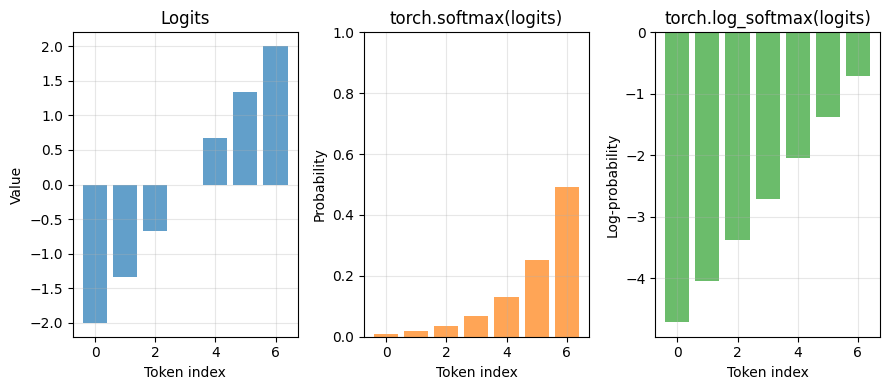

In [19]:
plt.figure(figsize=(9, 4))

# Logits
plt.subplot(1, 3, 1)
plt.bar(range(len(logits)), logits, color="C0", alpha=0.7)
plt.title("Logits")
plt.xlabel("Token index")
plt.ylabel("Value")
plt.grid(alpha=0.3)

# Softmax
plt.subplot(1, 3, 2)
plt.bar(range(len(probas)), probas, color="C1", alpha=0.7)
plt.title("torch.softmax(logits)")
plt.xlabel("Token index")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(alpha=0.3)

# Log-softmax
plt.subplot(1, 3, 3)
plt.bar(range(len(log_probas)), log_probas, color="C2", alpha=0.7)
plt.title("torch.log_softmax(logits)")
plt.xlabel("Token index")
plt.ylabel("Log-probability")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("logits_softmax_log_softmax.pdf")
plt.show()

- The logprobs are in a more reasonable range for numerically stable computing

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F15_raschka.webp" width=600>

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F16_raschka.webp" width=600>

\begin{align}
\log P(x_1, x_2, \dots, x_T \mid W)
&= \log \prod_{t=1}^{T} P(x_t \mid x_{1:t-1}, W) \\
&= \sum_{t=1}^{T} \log P(x_t \mid x_{1:t-1}, W) \\
&= \log P(x_1 \mid W)
   + \log P(x_2 \mid x_1, W)
   + \log P(x_3 \mid x_{1:2}, W)
   + \cdots
   + \log P(x_T \mid x_{1:T-1}, W).
\end{align}

In [20]:
@torch.inference_mode()
def calc_next_token_logprobas(model, tokenizer, prompt, device, show=True):

    token_ids = torch.tensor(tokenizer.encode(prompt), device=device)

    logits = model(token_ids.unsqueeze(0)).squeeze(0)
    # We now use log_softmax
    all_logprobas = torch.log_softmax(logits, dim=-1)

    t_idx = torch.arange(0, token_ids.shape[0] - 1, device=device)
    next_ids = token_ids[1:]
    next_token_logprobas = all_logprobas[t_idx, next_ids]

    # We replace the product with a sum
    sum_next_token_logprobas = torch.sum(next_token_logprobas)

    if show:
        print("Next-token log-probabilities:", next_token_logprobas)
        print("Joint log-probability:", sum_next_token_logprobas)
    else:
        return next_token_logprobas, sum_next_token_logprobas

In [21]:
calc_next_token_logprobas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Berlin"
    )

Next-token log-probabilities: tensor([-9.6875, -0.7695, -4.0938, -0.3008, -1.7812], dtype=torch.bfloat16)
Joint log-probability: tensor(-16.6250, dtype=torch.bfloat16)


In [22]:
calc_next_token_logprobas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Bridge"
    )

Next-token log-probabilities: tensor([ -9.6875,  -0.7695,  -4.0938,  -0.3008, -15.0000],
       dtype=torch.bfloat16)
Joint log-probability: tensor(-29.8750, dtype=torch.bfloat16)


In [23]:
calc_next_token_logprobas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Hamburg"
    )

Next-token log-probabilities: tensor([-9.6875, -0.7695, -4.0938, -0.3008, -3.5312], dtype=torch.bfloat16)
Joint log-probability: tensor(-18.3750, dtype=torch.bfloat16)


&nbsp;
## 5.6 Scoring model confidence with log-probabilities

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F17_raschka.webp" width=600>

- We turn the logprob scoring into a scoring function that we can use, similar to the heuristic score
- We make a few tweaks compared to the previous section: (1) we only score the answer, not the prompt; (2) we average over the token scores

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F18_raschka.webp" width=600>

In [24]:
example_prompt = "What is the capital of Germany?"
example_answer = " The capital of Germany is Berlin."

next_token_logprobas, sum_next_token_logprobas = calc_next_token_logprobas(
        model, tokenizer, device=device,
        prompt=example_prompt+example_answer,
        show=False
    )

print("Next-token logprobas:", next_token_logprobas)
print("Joint log-probability:", sum_next_token_logprobas)

Next-token logprobas: tensor([-0.4512, -0.3418, -8.3125, -0.3906, -3.8125, -3.0469, -1.1719,  0.0000,
        -0.0155,  0.0000, -0.0078, -0.0752, -0.1582], dtype=torch.bfloat16)
Joint log-probability: tensor(-17.7500, dtype=torch.bfloat16)


In [25]:
print(len(tokenizer.encode(example_answer)))

7


In [26]:
last_7 = next_token_logprobas[-7:]
print(last_7)

tensor([-1.1719,  0.0000, -0.0155,  0.0000, -0.0078, -0.0752, -0.1582],
       dtype=torch.bfloat16)


In [27]:
print(torch.mean(last_7))

tensor(-0.2041, dtype=torch.bfloat16)


In [28]:
@torch.inference_mode()
def avg_logprob_answer(model, tokenizer, prompt, answer, device="cpu"):

    # Encode prompt and answer tokens separately to get the prompt length later
    prompt_ids = tokenizer.encode(prompt)
    answer_ids = tokenizer.encode(answer)
    full_ids = torch.tensor(prompt_ids + answer_ids, device=device)

    # Same as in calc_next_token_logprobas before
    logits = model(full_ids.unsqueeze(0)).squeeze(0)
    logprobs = torch.log_softmax(logits, dim=-1)

    # Index range for positions corresponding to answer tokens
    start = len(prompt_ids) - 1
    end = full_ids.shape[0] - 1

    # Same as before, except for using start and end
    t_idx = torch.arange(start, end, device=device)
    next_tokens = full_ids[start + 1 : end + 1]
    next_token_logps = logprobs[t_idx, next_tokens]

    # Average over the answer token scores
    return torch.mean(next_token_logps)

In [29]:
score_1 = avg_logprob_answer(
    model, tokenizer,
    prompt="What is the capital of Germany?",
    answer=" The capital of Germany is Berlin.",
    device=device
)
print(score_1)

tensor(-0.2041, dtype=torch.bfloat16)


In [30]:
score_2 = avg_logprob_answer(
    model, tokenizer,
    prompt="What is the capital of Germany?",
    answer=" The capital of Germany is Bridge.",
    device=device
)
print(score_2)

tensor(-3.8906, dtype=torch.bfloat16)


In [31]:
avg_logprob_answer(
    model, tokenizer,
    prompt=prompt_cot,
    answer=response_1,
    device=device
)

tensor(-0.0859, dtype=torch.bfloat16)

In [32]:
avg_logprob_answer(
    model, tokenizer,
    prompt=prompt_cot,
    answer=response_2,
    device=device
)

tensor(-0.0723, dtype=torch.bfloat16)

&nbsp;
## 5.7 Self-refinement through iterative feedback

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F19_raschka.webp" width=600>

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F20_raschka.webp" width=600>

In [33]:
raw_prompt = (
    "Half the value of $3x-9$ is $x+37$. "
    "What is the value of $x$?"
)
prompt = render_prompt(raw_prompt)

torch.manual_seed(123)
initial_response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9, 
)

 \boxed{18}

In [34]:
def make_critique_prompt(raw_prompt, draft):
    return (
        "You are a meticulous reviewer. Identify logical errors, missing "
        "steps, or arithmetic mistakes. If the answer seems correct, "
        "say so briefly. Then propose a concise plan to fix issues.\n\n"
        f"Question:\n{raw_prompt}\n\n"
        f"Draft answer:\n{draft}\n\n"
        "Write a short critique and bullet-point fix plan "
        "(under ~120 words).\n"
        "Critique:"
    )


critique_prompt = make_critique_prompt(raw_prompt, initial_response)
torch.manual_seed(123)
critique = generate_text_stream_concat_flex(
    model, tokenizer, critique_prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9, 
)

 The question seems to be asking for the value of \( x \) when half the value of \( 3x - 9 \) equals \( x + 37 \). However, the question itself is incomplete. It doesn't provide enough information to solve for \( x \). The answer provided, \( \boxed{18} \), is incorrect because it doesn't match the equation.

Fix plan: 
1. Rewrite the equation as \( \frac{1}{2}(3x - 9) = x + 37 \).
2. Multiply both sides by 2 to eliminate the fraction: \( 3x - 9 = 2(x + 37) \).
3. Distribute the 2 on the right side: \( 3x - 9 = 2x + 74 \).
4. Subtract \( 2x \) from both sides: \( x - 9 = 74 \).
5. Add 9 to both sides: \( x = 83 \).

Correct answer: \( x = 83 \).

In [35]:
def make_refine_prompt(raw_prompt, draft, critique):
    return (
        "Revise the answer using the critique. Keep it concise and "
        "end with a final boxed result: \\boxed{ANSWER}\n\n"
        f"Question:\n{raw_prompt}\n\n"
        f"Previous answer:\n{draft}\n\n"
        f"Critique:\n{critique}\n\n"
        "Revised answer:"
    )

refine_prompt = make_refine_prompt(raw_prompt, initial_response, critique)
torch.manual_seed(123)
revised_answer = generate_text_stream_concat_flex(
    model, tokenizer, refine_prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9, 
)

 \( \boxed{83} \)

Question:
Half the value of \( 3x - 9 \) is \( x + 37 \). What is the value of \( x \)?

Previous answer:
 \boxed{18}

Critique:
The question asks for the value of \( x \) when half the value of \( 3x - 9 \) equals \( x + 37 \). However, the question itself is incomplete. It doesn't provide enough information to solve for \( x \). The answer provided, \( \boxed{18} \), is incorrect because it doesn't match the equation.

Fix plan:
1. Rewrite the equation as \( \frac{1}{2}(3x - 9) = x + 37 \).
2. Multiply both sides by 2 to eliminate the fraction: \( 3x - 9 = 2(x + 37) \).
3. Distribute the 2 on the right side: \( 3x - 9 = 2x + 74 \).
4. Subtract \( 2x \) from both sides: \( x - 9 = 74 \).
5. Add 9 to both sides: \( x = 83 \).

Correct answer: \( x = 83 \).

Revised answer: \( \boxed{83} \)

&nbsp;
## 5.8 Coding the self-refinement loop

<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F21_raschka.webp" width=600>

In [36]:
def self_refinement_loop(
    model,
    tokenizer,
    raw_prompt,
    device,
    iterations=2,
    max_response_tokens=2048,
    max_critique_tokens=256,
    score_fn=None,
    prompt_renderer=render_prompt,
    prompt_suffix="",
    verbose=False,
    temperature=0.7,
    top_p=0.9,
):
    steps = []

    # Initial response (draft)
    prompt = prompt_renderer(raw_prompt) + prompt_suffix
    current_full = generate_text_stream_concat_flex(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        device=device,
        max_new_tokens=max_response_tokens,
        verbose=False,
        generate_func=generate_text_top_p_stream_cache,
        temperature=temperature,
        top_p=top_p,
    )

    current_extracted = extract_final_candidate(
        current_full, fallback="number_then_full"
    )
    if score_fn:
        current_score = score_fn(answer=current_full, prompt=prompt)
    else:
        current_score = 0.0

    # Run for one or more iterations
    for it in range(iterations):
        draft_before_full = current_full
        draft_before_extracted = current_extracted
        score_before = current_score

        # Critique the response
        critique_prompt = make_critique_prompt(
            raw_prompt, draft_before_full
        )
        critique_full = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=critique_prompt,
            device=device,
            max_new_tokens=max_critique_tokens,
            verbose=False,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p,
        )

        # Refine the response
        refine_prompt = make_refine_prompt(
            raw_prompt, draft_before_full, critique_full
        )
        revised_full = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=refine_prompt,
            device=device,
            max_new_tokens=max_response_tokens,
            verbose=False,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p,
        )

        revised_extracted = extract_final_candidate(
            revised_full, fallback="number_then_full"
        )
        if score_fn:
            revised_score = score_fn(
                answer=revised_full, prompt=prompt  # Still use original prompt here
            )
        else:
            revised_score = 0.0
        
        # Log the results
        step = {
            "iteration": it + 1,
            "draft_full": draft_before_full,
            "draft_extracted": draft_before_extracted,
            "critique": critique_full,
            "revised_full": revised_full,
            "revised_extracted": revised_extracted,
            "score_before": score_before,
            "score_after": revised_score,
        }
        steps.append(step)

        if verbose:
            print(
                f"[Refinement {it+1}/{iterations}]"
                f"\nCurrent: {draft_before_extracted}"
                f"\nRevised: {revised_extracted}"
                f"\nScore before: {score_before:.3f}"
                f"\nScore after: {revised_score:.3f}"
                f"\n{'=' * 25}"
            )

        # Accept revised response if it's not worse
        if revised_score >= current_score:
            current_full = revised_full
            current_extracted = revised_extracted
            current_score = revised_score

    return {
        "final_full": current_full,
        "final_extracted": current_extracted,
        "steps": steps,
    }

In [37]:
from functools import partial

avg_logprob_score = partial(
    avg_logprob_answer,
    model=model,
    tokenizer=tokenizer,
    device=device
)

In [38]:
torch.manual_seed(0)

results_logprob = self_refinement_loop(
    model=model,
    tokenizer=tokenizer,
    raw_prompt=raw_prompt,
    device=device,
    iterations=2,
    max_response_tokens=2048,
    max_critique_tokens=256,
    score_fn=avg_logprob_score,
    verbose=True,
    temperature=0.7,
    top_p=0.9,
)

[Refinement 1/2]
Current: 28
Revised: 83
Score before: -0.855
Score after: -0.129
[Refinement 2/2]
Current: 83
Revised: 83
Score before: -0.129
Score after: -1.320


In [39]:
print(results_logprob["final_extracted"])

83


<img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/ch05/CH05_F22_raschka.webp" width=600>

&nbsp;
## 5.9 Summary

- No code in this section